In [1]:
torch.setdefaulttensortype('torch.FloatTensor')

### Load `Integral` and test it right away

In [2]:
require 'image'
local lena = image.lena():mean(1):squeeze()[{{1,4}, {1,4}}]

Integral = nil
debug.getregistry()['Integral'] = nil 
package.loaded['Integral-c'] = nil
package.loaded['Integral-c-multi'] = nil
package.loaded['Integral-jit'] = nil
package.loaded['Integral-jit-multi'] = nil
package.loaded['Integral-cuda-multi'] = nil
require 'Integral-jit-multi'

-- compute true forward and backward results for some data
local intGold = Integral(16, 4, 4)
local params, gradParamsGold = intGold:getParameters()

local forwardGold = intGold:forward(lena)
local gradInputGold = intGold:backward(lena, forwardGold)

-- remove the old slow class
Integral = nil
debug.getregistry()['Integral'] = nil 
package.loaded['Integral-c'] = nil
package.loaded['Integral-c-multi'] = nil
package.loaded['Integral-jit'] = nil
package.loaded['Integral-jit-multi'] = nil
package.loaded['Integral-cuda-multi'] = nil

-- require the new fast class
require 'Integral-cuda-multi'

local intTest = Integral(16, 4, 4):cuda()
local paramsTest, gradParamsTest = intTest:getParameters()

paramsTest:copy(params)
intTest:recalculateArea()

lena = lena:type(intTest:type())

-- compare results
local forwardTest = intTest:forward(lena)
local forwardErr = (forwardGold - forwardTest:float()):abs():sum() / 
                   forwardTest:nElement() / torch.abs(forwardGold):mean()
print('Output mean relative error:', forwardErr * 100 .. ' %')

local gradInputTest = intTest:backward(lena, forwardGold:type(intTest:type()))
local gradInputErr = (gradInputGold - gradInputTest:float()):abs():sum() / 
                     gradInputTest:nElement() / torch.abs(gradInputGold):mean()
print('gradInput mean relative error:', gradInputErr * 100 .. ' %')
local gradParamsErr = (gradParamsGold - gradParamsTest:float()):abs():sum() / 
                      gradParamsTest:nElement() / torch.abs(gradParamsGold):mean()
print('gradParams mean relative error:', gradParamsErr * 100 .. ' %')

assert(forwardErr    < 1e-6)
assert(gradInputErr  < 1e-6)
assert(gradParamsErr < 7e-4)

Output mean relative error:	1.3956582564299e-06 %	


gradInput mean relative error:	6.0973558033049e-07 %	
gradParams mean relative error:	2.8068720841962e-05 %	


### Test multi-channel vs single-channel `Integral`

Test forward pass

In [2]:
local nInputCh = 5
local nWindows = 7

require 'image'
torch.manualSeed(3)
local input = torch.rand(nInputCh, 234, 234)

Integral = nil
debug.getregistry()['Integral'] = nil 
package.loaded['Integral-c'] = nil
package.loaded['Integral-c-multi'] = nil
package.loaded['Integral-jit'] = nil
package.loaded['Integral-jit-multi'] = nil
package.loaded['Integral-cuda-multi'] = nil
require 'Integral-jit-multi'

-- compute true forward result for some data
local intGold = Integral(nWindows, 234, 234)
local params, gradParamsGold = intGold:getParameters()

local forwardGold = torch.Tensor(nInputCh*nWindows, 234, 234)
for i = 1,nInputCh do
    forwardGold[{{(i-1)*nWindows+1, i*nWindows}}]:copy(intGold:forward(input[i]))
end

-- remove the single-channel class
Integral = nil
debug.getregistry()['Integral'] = nil 
package.loaded['Integral-c'] = nil
package.loaded['Integral-c-multi'] = nil
package.loaded['Integral-jit'] = nil
package.loaded['Integral-jit-multi'] = nil
package.loaded['Integral-cuda-multi'] = nil

-- require the new multi-channel class
require 'Integral-cuda-multi'

local intTest = Integral(nWindows, 234, 234)
for i,member in ipairs{'xMin','xMax','yMin','yMax'} do
    intTest[member] = intGold[member]
end
intTest:recalculateArea()

local forwardTest = intTest:forward(input)

local forwardErr = (forwardGold - forwardTest):abs():sum() / 
                   forwardTest:nElement() / torch.abs(forwardGold):mean()
print('Output mean relative error:', forwardErr * 100 .. ' %')

./Integral-cuda-multi.lua:31: C/lib/libintegral-cuda.so: cannot open shared object file: No such file or directory
stack traceback:
	[C]: in function 'load'
	./Integral-cuda-multi.lua:31: in main chunk
	[C]: in function 'require'
	[string "local nInputCh = 5..."]:36: in main chunk
	[C]: in function 'xpcall'
	...ubb/Programs/Torch/install/share/lua/5.1/itorch/main.lua:210: in function <...ubb/Programs/Torch/install/share/lua/5.1/itorch/main.lua:174>
	...ubb/Programs/Torch/install/share/lua/5.1/lzmq/poller.lua:75: in function 'poll'
	.../Programs/Torch/install/share/lua/5.1/lzmq/impl/loop.lua:307: in function 'poll'
	.../Programs/Torch/install/share/lua/5.1/lzmq/impl/loop.lua:325: in function 'sleep_ex'
	.../Programs/Torch/install/share/lua/5.1/lzmq/impl/loop.lua:370: in function 'start'
	...ubb/Programs/Torch/install/share/lua/5.1/itorch/main.lua:389: in main chunk
	[C]: in function 'require'
	(command line):1: in main chunk
	[C]: at 0x00405e40: 

### Gradcheck

In [8]:
torch.setdefaulttensortype('torch.FloatTensor')

In [30]:
nParam = (not nParam or nParam == 5) and 1 or nParam + 1
print(nParam)

1	


In [37]:
Integral = nil
IntegralSmartNorm = nil
debug.getregistry()['Integral'] = nil 
debug.getregistry()['IntegralSmartNorm'] = nil 
package.loaded['Integral-c'] = nil
package.loaded['Integral-c-multi'] = nil
package.loaded['Integral-jit'] = nil
package.loaded['Integral-jit-multi'] = nil
package.loaded['Integral-cuda-multi'] = nil
package.loaded['IntegralSmartNorm'] = nil
require 'IntegralSmartNorm'

Integral = IntegralSmartNorm

local nInputCh = 1
local nWindows = 1
local imSize = 20

t = 'torch.CudaTensor'

torch.manualSeed(666)
input = image.convolve(torch.rand(nInputCh, imSize, imSize):pow(3), 
                                image.gaussian(math.max(1,imSize/3)), 'same'):type(t)
input:add(-input:mean())

target = image.convolve(torch.rand(nInputCh*nWindows, imSize, imSize):pow(3), 
                                image.gaussian(math.max(1,imSize/3)), 'same'):type(t)
target:add(-target:mean())

int = Integral(nWindows, imSize, imSize):type(t)
int.exact = true
int.smart = true

net = int
int.xMin[1] = 0
int.xMax[1] = 0
int.yMin[1] = 0
int.yMax[1] = 0

-- int.xMin[2] = -0.9
-- int.xMax[2] = 1.75
-- int.yMin[2] = -0.2
-- int.yMax[2] = -0.4

-- require 'nn'
-- net = nn.Sequential()
-- net:add(int)
-- net:add(nn.SpatialConvolutionMM(nInputCh*nWindows, 8, 1, 1, 1, 1)) 
-- net:add(nn.LeakyReLU(0.01))
-- net:add(Integral(4, imSize, imSize))
-- net:add(nn.SpatialConvolutionMM(3*4, 8, 1, 1, 1, 1))
-- net:add(nn.Reshape(8, imSize*imSize))
-- net:add(nn.Transpose({2, 1}))

-- target = torch.IntTensor(imSize*imSize)
-- target:apply(function() return torch.random(8) end)

crit = nn.MSECriterion():type(t)
-- crit = nn.CrossEntropyCriterion()

param = {}
loss = {}
dL_dParam_nn = {}
dL_dParam_diff = {}

-- nParam = 1 -- 1,2,3,4 <-> xMin,yMin,xMax,yMax

if -- ***********************
nParam == 1 then int.xMax[1] = imSize*2 elseif
nParam == 2 then int.yMax[1] = imSize*2 elseif
nParam == 3 then int.xMin[1] = -imSize*2 elseif
nParam == 4 then int.yMin[1] = -imSize*2 end

-- int:recalculateArea()

local stepSize = 0.5
local maxStep = 150
local innerStepSize = 0.01 * (nParam <= 2 and -1 or 1)

for i = 1,maxStep do
    if -- ***************************
    nParam == 1 then param[i] = int.xMax[1] + stepSize * (-maxStep+i) elseif
    nParam == 2 then param[i] = int.yMax[1] + stepSize * (-maxStep+i) elseif
    nParam == 3 then param[i] = int.xMin[1] + stepSize * (i-1) elseif
    nParam == 4 then param[i] = int.yMin[1] + stepSize * (i-1) elseif
    nParam == 5 then param[i] = -100 + i*stepSize end
    
    loss[i] = -666
    dL_dParam_nn[i] = -666
    dL_dParam_diff[i] = -666
end

for i = 1,#param do
    net:zeroGradParameters()
    
    if -- ***************************
    nParam == 1 then int.xMin[1] = param[i] elseif
    nParam == 2 then int.yMin[1] = param[i] elseif
    nParam == 3 then int.xMax[1] = param[i] elseif
    nParam == 4 then int.yMax[1] = param[i] elseif
    nParam == 5 then input[{1,1,1}] = param[i] end
    
--     int:recalculateArea()
    
    pred = net:forward(input)    
    currLoss = crit:forward(pred, target)
    dLoss_dOutput = crit:backward(pred, target)
    net:backward(input, dLoss_dOutput)
--     net:updateGradInput(input, dLoss_dOutput)
--     if i >= 1 and i <= 2 then
--         print('input:')
--         print(input)
--         print('pred:')
--         print(pred)
--         print('outputOnes:')
--         print(int.outputOnes)
--         print('gradOut by INonNorm:')
--         print(int.cdiv.gradInput[1])
--         print('gradOut by 1-s:')
--         print(int.cdiv.gradInput[2])
--     end
--     net:accGradParameters(input, dLoss_dOutput, 1)
--     if i >= 1 and i <= 2 then
--         print('gradOut by INonNorm multipliers:')
--         print(int.cdiv.gradInput[1])
--         print('gradOut by 1-s multipliers:')
--         print(int.cdiv.gradInput[2])
--         print('Manual deriv = ' .. int.gradXMin[1])
--     end
    
    loss[i] = currLoss
    
    if -- ***************************
    nParam == 1 then dL_dParam_nn[i] = int.gradXMin[1] elseif
    nParam == 2 then dL_dParam_nn[i] = int.gradYMin[1] elseif
    nParam == 3 then dL_dParam_nn[i] = int.gradXMax[1] elseif
    nParam == 4 then dL_dParam_nn[i] = int.gradYMax[1] elseif
    nParam == 5 then dL_dParam_nn[i] = int.gradInput[{1,1,1}] end
    
    -- step forward a bit
    if -- ***************************
    nParam == 1 then int.xMin[1] = param[i] + innerStepSize elseif
    nParam == 2 then int.yMin[1] = param[i] + innerStepSize elseif
    nParam == 3 then int.xMax[1] = param[i] + innerStepSize elseif
    nParam == 4 then int.yMax[1] = param[i] + innerStepSize elseif
    nParam == 5 then input[{1,1,1}] = param[i] + innerStepSize end
    
--     int:recalculateArea()
    
    pred = net:forward(input)
    currLoss = crit:forward(pred, target)
    dLoss_dOutput = crit:backward(pred, target)
    gradInput = net:backward(input, dLoss_dOutput)
    
    dL_dParam_diff[i] = (currLoss - loss[i]) / innerStepSize
    
    collectgarbage()
    
    if i % 50 == 0 then print(i) end
end

for i = 1,#param-1 do
--     dL_dParam_diff[i] = (loss[i+1] - loss[i]) / stepSize
end

param[#param] = nil
dL_dParam_nn[#dL_dParam_nn] = nil
dL_dParam_diff[#dL_dParam_diff] = nil
loss[#loss] = nil

50	


100	


150	


In [39]:
require 'gnuplot'

gnuplot.figure(1)
gnuplot.plot{
    {'manual', torch.Tensor(param), torch.Tensor(dL_dParam_nn), '-'},
    {'diff'  , torch.Tensor(param), torch.Tensor(dL_dParam_diff), '-'},
--     {'zero'  , torch.Tensor{0, 0}, torch.Tensor{torch.Tensor(dL_dParam_diff):min(), torch.Tensor(dL_dParam_diff):max()}, '-'},
--     {'loss'  , torch.Tensor(param), torch.Tensor(loss), '-'},
}
gnuplot.movelegend('right', 'middle')
gnuplot.xlabel('parameter')
gnuplot.ylabel('dLoss / dParameter')

In [27]:
function round_down(x)
    local rounded = math.floor(x)
    return rounded, x-rounded -- return integer and fractional parts
end

function round_up(x)
    local rounded = math.ceil(x)
    return rounded, rounded-x -- return integer and fractional parts
end

In [45]:
require 'image'
local img = image.scale(image.lena():mean(1):squeeze(), 6, 6)

int = Integral(1, img:size(1), img:size(2))
int.exact = true
int.smart = true
int.xMin[1] = 3
int.xMax[1] = 5
int.yMin[1] = 3
int.yMax[1] = 5

int:zeroGradParameters()
pred = int:forward(img)
loss = crit:forward(pred, img*2)
gradOutput = crit:backward(pred, img)
int:backward(img, gradOutput)
print('Manual deriv = ' .. int.gradXMax[1])

local stepSize = 0.01
int.xMax[1] = int.xMax[1] + stepSize
loss_step = crit:forward(int:forward(img), img*2)
print('Diff deriv = ' .. (loss_step - loss) / stepSize)

Manual deriv = 0	


Diff deriv = 0	


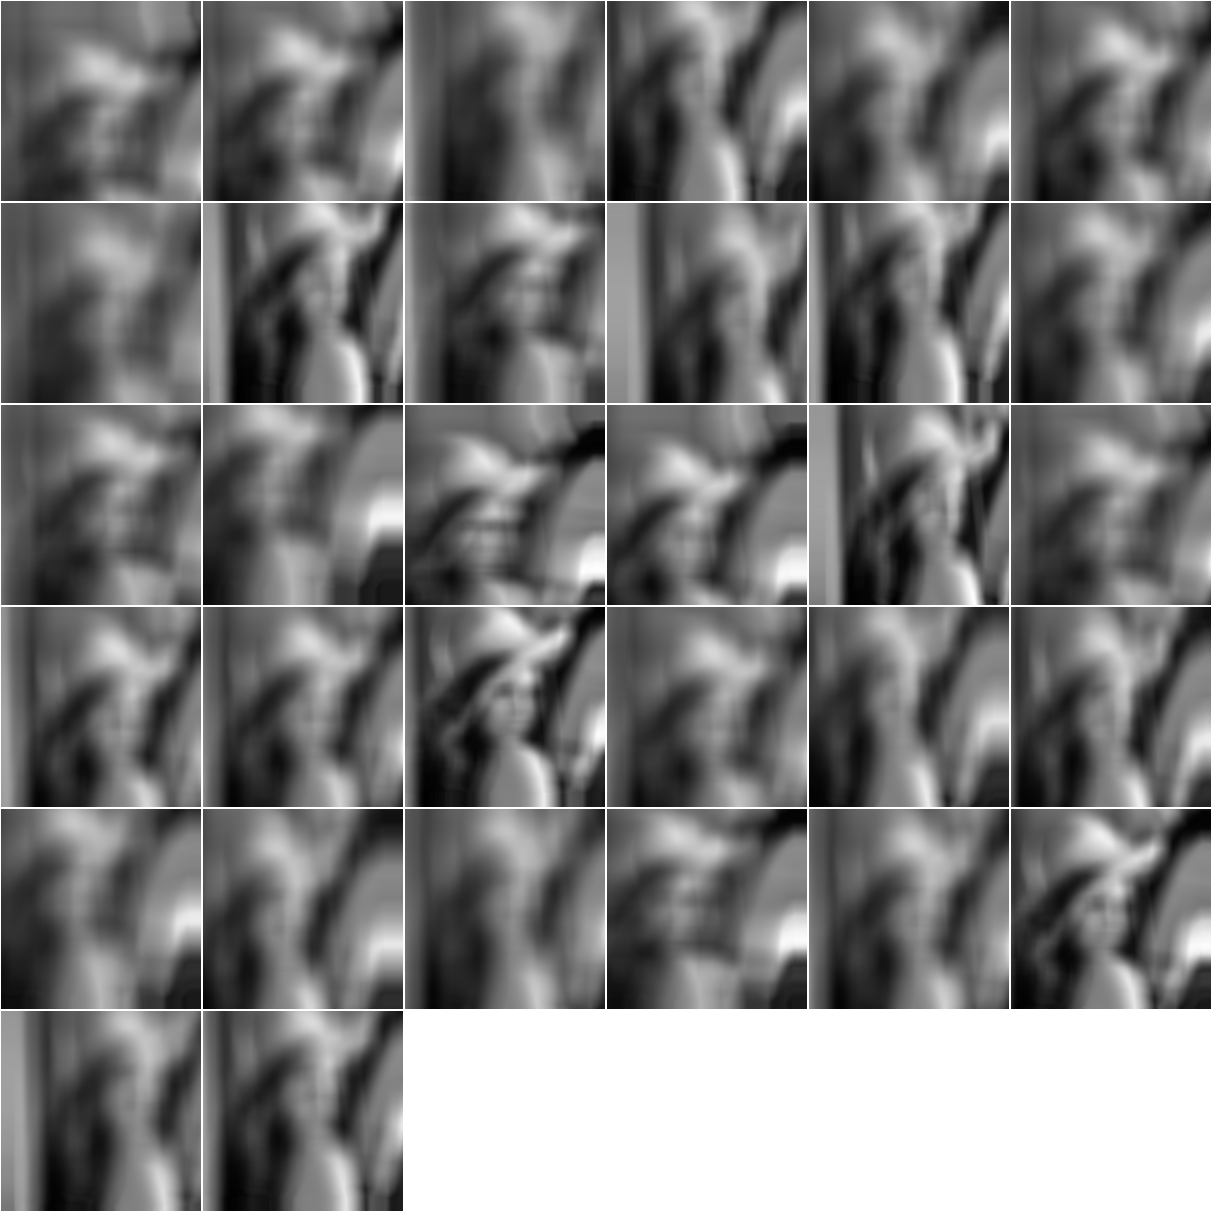

In [21]:
require 'image'
local img = image.scale(image.lena():mean(1):squeeze(), 200, 200)

-- img = torch.rand(3, 3)

-- torch.manualSeed(660)
int = Integral(32, img:size(1), img:size(2))
int.exact = true
-- int.xMin[1] = 0
-- int.xMax[1] = 0
-- int.yMin[1] = 0.5
-- int.yMax[1] = 0.5

-- print(img)
-- print(int:forward(img)[7][{{1, 30}, {194, 200}}])
-- print(int.outputOnes[7][{{1, 30}, {194, 200}}])
-- print(int.outputNonNorm[7][{{1, 30}, {194, 200}}][{{}, {4,-1}}])
itorch.image(int:forward(img))

### Measure execution times

Input: 1024x768 image

* **Forward** experiment: compute `16x1024x768` feature maps 4 times
* **Backward** experiment: do a backprop step (from the "after `Forward`" state) 4 times

#### Forward

* $2.993 \pm 0.242$ sec. (LuaJIT loop + exact fractional parts computation)	
* $0.487 \pm 0.087$ sec. (LuaJIT loop)
* $0.358 \pm 0.019$ sec. (C loop)
* $0.321 \pm 0.037$ sec. (+ precomputed `t,b,l,r`)
* $0.165 \pm 0.058$ sec. (+ parallel)
* $0.140 \pm 0.066$ sec. (+ inline `areaCoeff` multiplication)
* $0.048 \pm 0.032$ sec. (after GPU modifications, i dunno why lol)


`IntegralSmartNorm`:
* $2.147 \pm 0.223$ sec. (exact)
* $0.381 \pm 0.150$ sec. (with rounding)

*CUDA, GTX 970*

* $0.03152 \pm 0.0084$ sec. ('single' kernel)
* $0.03481 \pm 0.0081$ sec. ('multi' kernel, block size = 1x32x32)
* $0.08079 \pm 0.0123$ sec. ('multi' kernel, block size = 4x16x16)

`IntegralSmartNorm`:

* $0.2198 \pm 0.0277$ sec. (exact)
* $0.0616 \pm 0.0095$ sec. (with rounding)

#### Backward

* $2.660 \pm 0.252$ sec. (LuaJIT)
* $1.956 \pm 0.385$ sec. (C parallel `updGI`)
* $1.616 \pm 0.274$ sec. (+ C gradParam loop, precomputed `t,b,l,r`)
* $1.357 \pm 0.136$ sec. (+ parallelize by deltas -- 2 threads)
* $1.991 \pm 0.358$ sec. (+ parallelize by deltas -- 4 threads)
* $1.576 \pm 0.290$ sec. (+ parallelize by rows)
* $1.103 \pm 0.179$ sec. (after GPU modifications, i dunno why lol)

`IntegralSmartNorm`:

* $5.941 \pm 1.915$ sec. (exact)
* $3.659 \pm 0.611$ sec. (with rounding)

*CUDA, GTX 970*

* $0.5923 \pm 0.0413$ sec. (parallelized only `forward` (*affects `updateGradInput`*) with 'multi' kernel, block size = 1x32x32)
* $0.3409 \pm 0.0144$ sec. (+ parallel `backward`, 'single' kernel)

`IntegralSmartNorm`:

* $0.5736 \pm 0.0671$ sec. (exact)
* $0.5071 \pm 0.1763$ sec. (with rounding)

In [68]:
Integral = nil
debug.getregistry()['Integral'] = nil 
package.loaded['Integral-c'] = nil
package.loaded['Integral-c-multi'] = nil
package.loaded['Integral-jit'] = nil
package.loaded['Integral-jit-multi'] = nil
package.loaded['Integral-cuda-multi'] = nil
require 'Integral-cuda-multi'

./Integral-cuda-multi.lua:31: C/lib/libintegral-cuda.so: cannot open shared object file: No such file or directory
stack traceback:
	[C]: in function 'load'
	./Integral-cuda-multi.lua:31: in main chunk
	[C]: in function 'require'
	[string "Integral = nil..."]:8: in main chunk
	[C]: in function 'xpcall'
	...ubb/Programs/Torch/install/share/lua/5.1/itorch/main.lua:210: in function <...ubb/Programs/Torch/install/share/lua/5.1/itorch/main.lua:174>
	...ubb/Programs/Torch/install/share/lua/5.1/lzmq/poller.lua:75: in function 'poll'
	.../Programs/Torch/install/share/lua/5.1/lzmq/impl/loop.lua:307: in function 'poll'
	.../Programs/Torch/install/share/lua/5.1/lzmq/impl/loop.lua:325: in function 'sleep_ex'
	.../Programs/Torch/install/share/lua/5.1/lzmq/impl/loop.lua:370: in function 'start'
	...ubb/Programs/Torch/install/share/lua/5.1/itorch/main.lua:389: in main chunk
	[C]: in function 'require'
	(command line):1: in main chunk
	[C]: at 0x00405e40: 

In [40]:
h = 768
w = 1024
nMaps = 16

In [47]:
int = IntegralSmartNorm(nMaps, h, w):cuda()
int.exact = false
int.smart = true
params, gradParams = int:getParameters()

#### Forward experiment

In [48]:
img = torch.rand(h, w):type(int:type())
local repeats = 4
local timeRepeats = 20

int:forward(img)

times = torch.Tensor(timeRepeats)

for timeRepeat = 1,timeRepeats do

    local timer = torch.Timer()

    for _ = 1,repeats do
        int:forward(img)
    end

--     cutorch.synchronize()
    timer:stop()

    times[timeRepeat] = timer:time().real
    
    collectgarbage()
end

print(times:mean() .. ' +/- ' .. 2.1 * times:std() .. ' seconds')

0.061573934555054 +/- 0.00947026024127 seconds	


#### Backward experiment

In [50]:
img = torch.rand(h, w):type(int:type())
local repeats = 4
local timeRepeats = 15

times = torch.Tensor(timeRepeats)

local prediction = int:forward(img)
int:backward(img, prediction)

for timeRepeat = 1,timeRepeats do

    local timer = torch.Timer()

    for _ = 1,repeats do
        int._backwardDone = false
        int:backward(img, prediction)
    end

--     cutorch.synchronize()
    timer:stop()

    times[timeRepeat] = timer:time().real
    
    collectgarbage()
    
end

print(times:mean() .. ' +/- ' .. 2.1 * times:std() .. ' seconds')

0.49724982579549 +/- 0.056851713346913 seconds	
